In [3]:
!wget --header="Host: archive.ics.uci.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.101 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://archive.ics.uci.edu/ml/machine-learning-databases/00422/" "https://archive.ics.uci.edu/ml/machine-learning-databases/00422/wifi_localization.txt" -c -O 'wifi_localization.txt'

--2021-01-06 10:56:36--  https://archive.ics.uci.edu/ml/machine-learning-databases/00422/wifi_localization.txt
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import os

In [5]:
data = pd.read_csv("wifi_localization.txt",sep="\t",header=None)
data.columns = [f'feature_{i}' for i in data.columns]
target_column = data.columns.values[-1]
data

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7
0,-64,-56,-61,-66,-71,-82,-81,1
1,-68,-57,-61,-65,-71,-85,-85,1
2,-63,-60,-60,-67,-76,-85,-84,1
3,-61,-60,-68,-62,-77,-90,-80,1
4,-63,-65,-60,-63,-77,-81,-87,1
...,...,...,...,...,...,...,...,...
1995,-59,-59,-48,-66,-50,-86,-94,4
1996,-59,-56,-50,-62,-47,-87,-90,4
1997,-62,-59,-46,-65,-45,-87,-88,4
1998,-62,-58,-52,-61,-41,-90,-85,4


In [6]:
# sns.countplot(data['target'])

In [7]:
import math

def gini_impurity(arr):
  _,counts = np.unique(arr,return_counts=True)
  return 1 - np.sum((counts/len(arr))**2)

In [8]:
from sklearn.model_selection import train_test_split
x_train,x_test = train_test_split(data,test_size=0.2,random_state=99)

In [9]:
import scipy

class CustomDecisionTreeClassifier:

  def __init__(self,
               X,
               target_column="target",
               depth=0,
               max_depth=5):

    self.left = None
    self.center = None
    self.right = None
    self.data= X
    self.child_nodes = 3
    self.fkey = None
    self.max_depth = max_depth
    self.target_column = target_column
    self.depth = depth
    self.endpoints = None

    self.train(self.data)

    
  def __entropy(self,arr):
    values,counts = np.unique(arr,return_counts=True)
    probs = counts/len(arr)

    return -1*np.sum(probs*np.log2(probs))

  def __divide_data(self,df,column,
                    # fval
                    endpoints):
    
    if endpoints is None:    
      endpoints = np.linspace(df[column].min(),df[column].max(),self.child_nodes +1)

    x_left  = df[(df[column] <= endpoints[1])]
    x_center = df[(df[column] > endpoints[1]) & (df[column] <= endpoints[2])]
    x_right = df[(df[column] > endpoints[2])]

    return x_left,x_center,x_right


  def __information_gain(self,data,fkey,endpoints=None):
    
    left,center,right = self.__divide_data(data,fkey,endpoints)

    prob_l = float(left.shape[0]/data.shape[0])
    prob_c = float(center.shape[0]/data.shape[0])
    prob_r = float(right.shape[0]/data.shape[0])

    i_gain = self.__entropy(data[self.target_column].values) - (
         
        prob_l*self.__entropy(left[self.target_column].values) + 
        prob_c*(self.__entropy(center[self.target_column].values)) +
        prob_r*self.__entropy(right[self.target_column].values)
        
        )
        
    return i_gain
  
  def train(self,data):
    info_gains = []

    features = data.columns[:-1]

    for ix in features:
      info_gains.append(self.__information_gain(data,ix))
    
    index = np.argmax(info_gains)
    self.fkey = features[index]
    
    # print(self.fkey,info_gains,index)
    
    # if sum(info_gains) == 0:
    #   self.target_val = int(np.ceil(data[self.target_column].mean()))
    #   return self

    self.endpoints = np.linspace(data[self.fkey].min(),data[self.fkey].max(),self.child_nodes + 1)
    
    left,center,right = self.__divide_data(data,self.fkey,self.endpoints)
    
    if left.shape[0] == 0 or right.shape[0] == 0 or center.shape[0] == 0:
      self.target_val = int(np.ceil(data[self.target_column].mean()))
      return 
    
    if self.depth >= self.max_depth :
      self.target_val = int(np.ceil(data[self.target_column].mean()))
      # print("____")
      return 
    
    self.left = CustomDecisionTreeClassifier(left,depth=self.depth+1 ,max_depth = self.max_depth,target_column = self.target_column)
    self.center = CustomDecisionTreeClassifier(center,depth=self.depth+1 ,max_depth = self.max_depth,target_column = self.target_column)
    self.right = CustomDecisionTreeClassifier(right,depth=self.depth+1 ,max_depth = self.max_depth,target_column = self.target_column)

    self.target_val = int(np.ceil(data[self.target_column].mean()))
    return 

  def predict(self,test):

    if test[self.fkey] <= self.endpoints[1]:
      if self.left is None:
        return self.target_val
      
      return self.left.predict(test)
    
    elif (test[self.fkey] > self.endpoints[1]) & (test[self.fkey] <= self.endpoints[2]):
      if self.center is None:
        return self.target_val
      
      return self.center.predict(test)
    else:
      if self.right is None:
        return self.target_val
      
      return self.right.predict(test)

In [16]:
# print(x_train.columns)
from tqdm.notebook import tqdm
scores = []

for i in tqdm(range(1,10)):
  tree = CustomDecisionTreeClassifier(x_train,depth=1,max_depth=i,target_column=target_column)
  
  preds = []
  for ix in range(x_test.shape[0]):
    preds.append(tree.predict(x_test.iloc[ix]))

  from sklearn.metrics import accuracy_score
  score = accuracy_score(x_test[target_column],preds)
  scores.append(score)

Text(0, 0.5, 'Accuracy Score')

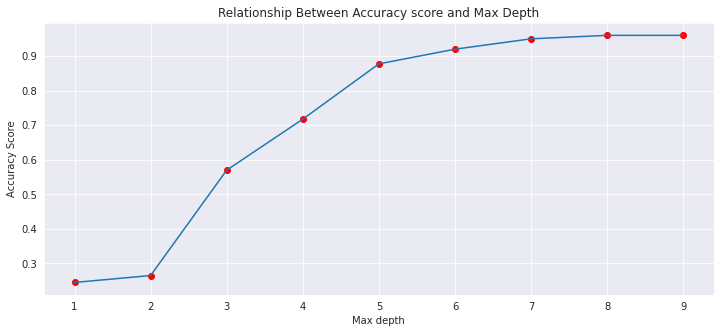

In [18]:
sns.set_style('darkgrid')

plt.figure(figsize=(12,5))
plt.scatter(range(1,10),scores,marker="o",color="red")
plt.title("Relationship Between Accuracy score and Max Depth")
plt.plot(range(1,10),scores)
plt.xlabel("Max depth")
plt.ylabel('Accuracy Score')

In [21]:
max_depth  = 4 
tree = CustomDecisionTreeClassifier(x_train,depth=1,max_depth=max_depth,target_column=target_column)

def print_level(tree , level):
  if tree == None : return
  if level is 1:
    print(tree.fkey,end=" ")
  
  print_level(tree.left,level-1)
  print_level(tree.center,level-1)
  print_level(tree.right,level-1)

for i in range(1,max_depth + 1):
  print(f'level {i}:: ',end=" ")
  print_level(tree,i)
  print()

level 1::  feature_0 
level 2::  feature_4 feature_0 feature_0 
level 3::  feature_3 feature_4 feature_0 feature_4 feature_0 feature_0 feature_0 feature_0 feature_0 
level 4::  feature_0 feature_3 feature_0 feature_3 feature_0 feature_0 feature_0 feature_0 feature_0 feature_2 feature_2 feature_4 feature_3 feature_6 feature_0 feature_0 feature_0 feature_0 feature_0 feature_0 feature_0 feature_0 feature_0 feature_0 
